In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background') # optional

from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import ClassicalRegister, QuantumRegister, Parameter
from qiskit import QuantumCircuit


# 1. Basics

## 1.1 Vectors and operators

### Vectors and states

In [2]:
#Define vectors in Dirac's notation
ket0 = [[1], [0]]
bra0 = [1, 0]

#Display vectors in LaTeX style
array_to_latex(ket0)

<IPython.core.display.Latex object>

In [3]:
#Define statevectors by Statevector class
sv_ket0 = Statevector(ket0)
print(sv_ket0)
sv_ket0.draw("latex")

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


<IPython.core.display.Latex object>

In [4]:
#Statevectors defined by coefficients
sv_bell = Statevector([0, np.sqrt(2)/2, -np.sqrt(2)/2, 0])

#Check if normalised
print(sv_bell.is_valid())

sv_bell.draw("latex")

True


<IPython.core.display.Latex object>

In [5]:
#Get info about a statevector
print(sv_bell.probabilities_dict())

#Projective (probabilistic) measure of a statevector
res = sv_bell.measure()
res

{'01': 0.5000000000000001, '10': 0.5000000000000001}


('10',
 Statevector([ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
             dims=(2, 2)))

### Operations and operators

In [6]:
#Define operators with Operator class
op_bra0 = Operator(bra0)
op_ket0 = Operator(ket0)

sx = Operator([[0, 1], [1, 0]])

In [7]:
#Tensor product
t = op_bra0.tensor(op_ket0)
array_to_latex(t)

<IPython.core.display.Latex object>

In [8]:
#Inner and outer product
braket = np.dot(op_bra0, op_ket0)
ketbra = np.outer(op_ket0, op_bra0)

array_to_latex(braket)

<IPython.core.display.Latex object>

In [9]:
#Import gates
from qiskit.circuit.library import HGate, CXGate
cnot = CXGate()

array_to_latex(cnot)

<IPython.core.display.Latex object>

More standard gates at https://qiskit.org/documentation/apidoc/circuit_library.html

In [10]:
#Check if unitary
sx.is_unitary()

True

In [11]:
#Pauli matrices
pauli_x = Pauli("X")
pauli_y = Pauli("Y")
pauli_z = Pauli("Z")

array_to_latex(pauli_y)

<IPython.core.display.Latex object>

## 1.2 Quantum Circuits

### First circuit: dense coding

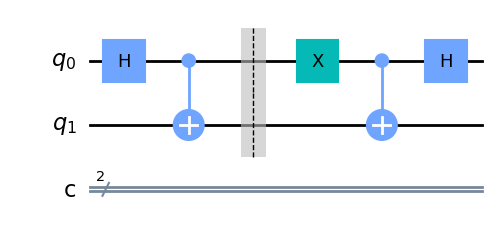

In [12]:
#Definition of a circuit
qc = QuantumCircuit(2, 2)   #QuantumCircuit(QuantumRegister(4), ClassicalRegister(3))

qc.h(0)                     #Apply an Hadamard gate to qubit 0
qc.cx(0, 1)                 #Apply a CNOT (controlled by qubit 0)

qc.barrier()                #Graphic divider

qc.x(0)                     #Apply a NOT (Alice operations in dense coding)
qc.cx(0, 1)
qc.h(0)

qc.draw("mpl")              #Show the circuit

In [13]:
#Matrix rappresentation of a circuit
qc_matrix = Operator(qc)
array_to_latex(qc_matrix)

<IPython.core.display.Latex object>

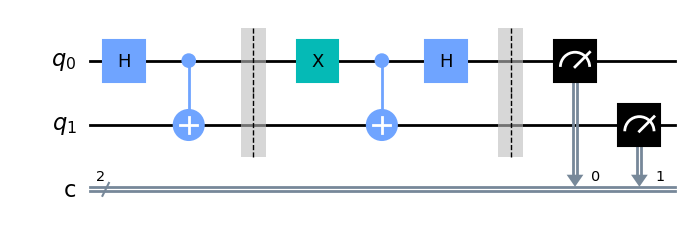

In [14]:
#Measure in a circuit
qc.barrier()                #Edit same circuit as before
qc.measure([0, 1], [0, 1])  #Projective measure of [qubits] into classical [bits]

qc.draw("mpl")

In [15]:
#Get access to results
sampler = Sampler()         #Sampler primitive to measure in the Z-basis

mis = sampler.run(qc)       #Save the outcome of the measure shots
mis.result().quasi_dists[0].binary_probabilities()

{'10': 0.9999999999999996}

### Teleportation

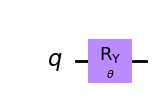

In [16]:
theta = Parameter(r"$\theta$")      #Define a parameter

#Define the control circuit
qr = QuantumRegister(1, 'q')        #Define a quantum register named "q"
qc = QuantumCircuit(qr)

qc.ry(theta, 0)                     #Rotate qubit 0 with theta

qc.draw('mpl')

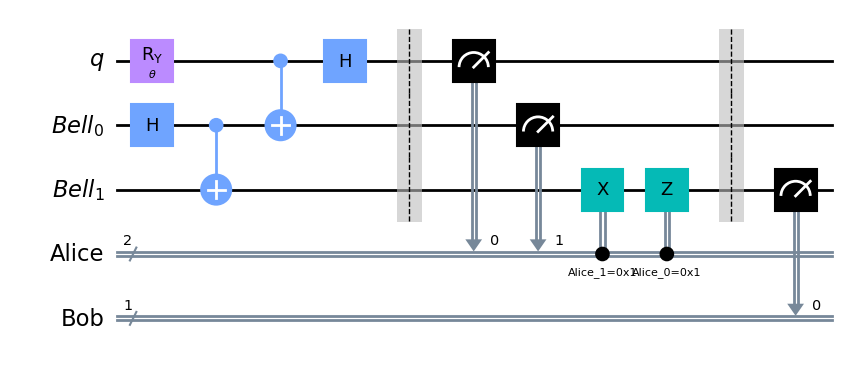

In [17]:
#Define the teleportation circuit
tele_qc = qc.copy()                         #Copy of a circuit
bell = QuantumRegister(2, 'Bell')
alice = ClassicalRegister(2, 'Alice')       #Define a classical register named "Alice"
bob = ClassicalRegister(1, 'Bob')
tele_qc.add_register(bell, alice, bob)      #Add registers to the circuit

#Bell state
tele_qc.h(1)
tele_qc.cx(1, 2)

#Alice's operations
tele_qc.cx(0, 1)
tele_qc.h(0)

#Alice's measurements
tele_qc.barrier()
tele_qc.measure([qr[0], bell[0]], alice)


#If condition: operations based on measure
tele_qc.x(2).c_if(alice[1], 1)
tele_qc.z(2).c_if(alice[0], 1)

#Bob's measurement
tele_qc.barrier()
tele_qc.measure(bell[1], bob)


tele_qc.draw("mpl")

In [18]:
#Measure the original state (note that tele_qc was a copy of the circuit)
qc.measure_all()            

In [21]:
#Confront the results
angle = 4*np.pi/7       #Angle theta to get an arbitrary initial state

#Access to the simulation backend
from qiskit import BasicAer, assemble, transpile
backend = BasicAer.get_backend('qasm_simulator')    
#Get the results
result_original = backend.run(assemble(transpile(qc.bind_parameters({theta: angle}), backend))).result()
result_tele = backend.run(assemble(transpile(tele_qc.bind_parameters({theta: angle}), backend))).result()

print(f"Original Dists: {result_original.get_counts()}")
print(f"Teleported Dists: {result_tele.get_counts()}")

Original Dists: {'1': 613, '0': 411}
Teleported Dists: {'1 10': 168, '0 01': 96, '1 11': 156, '1 00': 135, '0 10': 116, '0 11': 110, '0 00': 98, '1 01': 145}


Result(backend_name='qasm_simulator', backend_version='2.1.0', qobj_id='5ee3337b-65f9-4536-9853-c3ab364131bc', job_id='ff4ab87d-0b57-4176-ab0c-d68af9ae7565', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 604, '0x0': 420}), header=QobjExperimentHeader(qubit_labels=[['q', 0], ['Bell', 0], ['Bell', 1]], n_qubits=3, qreg_sizes=[['q', 1], ['Bell', 2]], clbit_labels=[['Alice', 0], ['Alice', 1], ['Bob', 0]], memory_slots=1, creg_sizes=[['Bob', 1]], name='circuit-124', global_phase=0.0, metadata={}), status=DONE, name='circuit-124', seed_simulator=508935711, time_taken=0.2915515899658203)], date=None, status=COMPLETED, header=QobjHeader(), time_taken=0.2915515899658203)


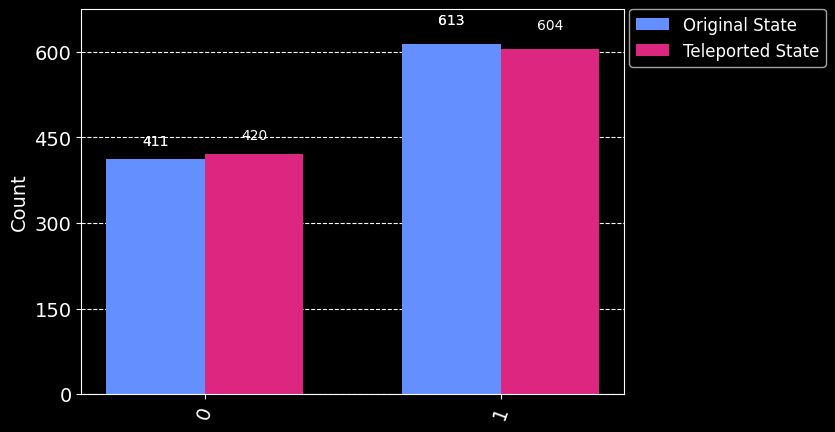

In [22]:
#Marginalization: from [Alice0Alice1Bob] to [Bob]
from qiskit.result import marginal_counts
tele_counts = marginal_counts(result_tele, [2]) #[2] to sum over [0, 1]
print(tele_counts)

#Visualize the counts
legend = ['Original State', 'Teleported State']
plot_histogram([result_original.get_counts(), tele_counts.get_counts()], legend=legend)